In [56]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import pandas

In [57]:
#load mnist dataset
mnist = datasets.load_digits()
X = mnist.data
y = mnist.target
y

array([0, 1, 2, ..., 8, 9, 8])

In [58]:
X.shape

(1797, 64)

In [59]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

In [60]:
# Standardize features
scaler=MinMaxScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)

In [61]:
Xtr=Xtr.reshape(-1,1, 8, 8)
Xte=Xte.reshape(-1,1, 8, 8)
Xtr.shape

(1437, 1, 8, 8)

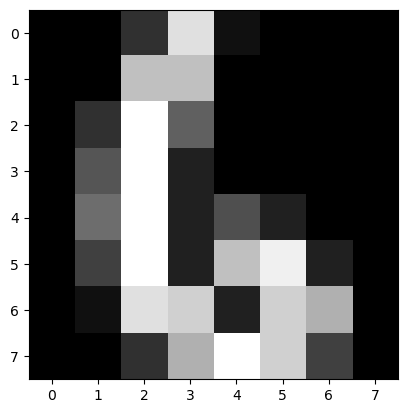

In [62]:
#image in black and white
plt.imshow(np.transpose(Xtr[0], (1, 2, 0)), cmap='gray')
plt.show()

In [63]:
class Encoder(nn.Module):
    def __init__(self,in_channels=1):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)   # (1,8,8) → (8,8,8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)  # (8,4,4) → (16,4,4)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # conv1 + relu + pool → (8,4,4)
        x = self.pool(F.relu(self.conv2(x)))  # conv2 + relu + pool → (16,2,2)
        return x  # latent shape: (16, 2, 2)

In [64]:
class Decoder(nn.Module):
    def __init__(self,in_channels=16):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=8, kernel_size=2, stride=2)   # (16,2,2) → (8,4,4)
        self.deconv2 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=2)  # (8,4,4) → (1,8,8)


    def forward(self, x):
        x = F.relu(self.deconv1(x))  # conv1 + relu + pool → (8,4,4)
        x = F.sigmoid(self.deconv2(x))  # conv2 + relu + pool → (1,8,8)
        return x

In [65]:
class ConvAutoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(ConvAutoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [66]:
num_epochs=50
lr=0.0005
batch_size=64

In [67]:
Xtr = torch.tensor(Xtr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.long)
yte = torch.tensor(yte, dtype=torch.long)

In [68]:
# Create DataLoaders
train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(Xte, yte), batch_size=batch_size, shuffle=False)

In [69]:
# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(in_channels=1)
decoder = Decoder()
model = ConvAutoencoder(encoder, decoder).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [70]:
#Train the model
for epoch in range(num_epochs):
    for data, _ in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [5/50], Loss: 0.118912
Epoch [10/50], Loss: 0.080107
Epoch [15/50], Loss: 0.061982
Epoch [20/50], Loss: 0.058005
Epoch [25/50], Loss: 0.049358
Epoch [30/50], Loss: 0.043555
Epoch [35/50], Loss: 0.036768
Epoch [40/50], Loss: 0.034975
Epoch [45/50], Loss: 0.031341
Epoch [50/50], Loss: 0.030976


In [71]:
#Evaluate reconstruction
model.eval()
with torch.no_grad():
    reconstructed = model(Xte).numpy()


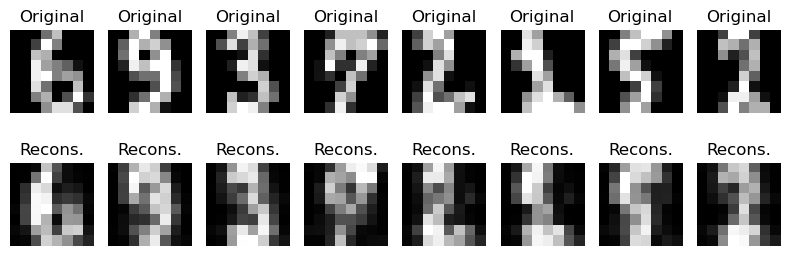

In [72]:
#Plot some reconstructions
n = 8
plt.figure(figsize=(8, 3))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(Xte[i].reshape(8, 8), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    
    # Reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(8, 8), cmap='gray')
    plt.title("Recons.")
    plt.axis("off")

plt.tight_layout()
plt.show()